## Import Necessary Functions

These are required to utilise functions specific for visualisations and perform machine learning.

In [61]:
## REQUIRED LIBRARIES
# For data wrangling 
import numpy as np
import pandas as pd


# For visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
pd.options.display.max_rows = None
pd.options.display.max_columns = None

### Load Raw Data

In [62]:
import pickle

#Load the training and testing split from the pickle file
with open('../data/train_test_data.pickle', 'rb') as file:
    train_test_split = pickle.load(file)


X_train_raw = train_test_split['X_train_raw']
y_train_raw = train_test_split['y_train_raw']
X_test_raw = train_test_split['X_test_raw']
y_test_raw = train_test_split['y_test_raw']

In [63]:
X_train_raw.shape, y_train_raw.shape, X_test_raw.shape, y_test_raw.shape

((8000, 13), (8000,), (2000, 13), (2000,))

### Load  different splits

In [64]:
with open('../data/train_splits.pickle', 'rb') as file:
    split_data = pickle.load(file)

## Standard Random Forest Classification
First we will train and test our model on the 4 different training splits and compute some metrics. We can then apply some methods to optimise how the model generalises to customer churn data.

In [65]:
from sklearn.ensemble import RandomForestClassifier 
#Create initial model 
model = RandomForestClassifier(random_state=6) #Use default parameters for now

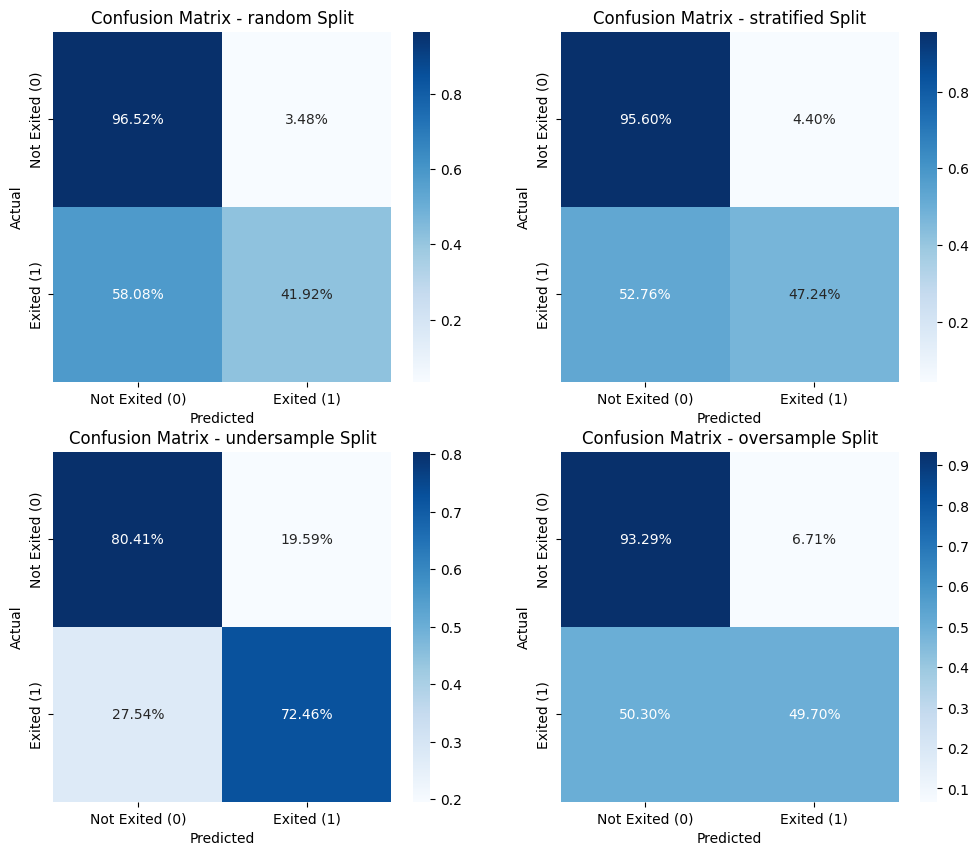

<Figure size 800x600 with 0 Axes>

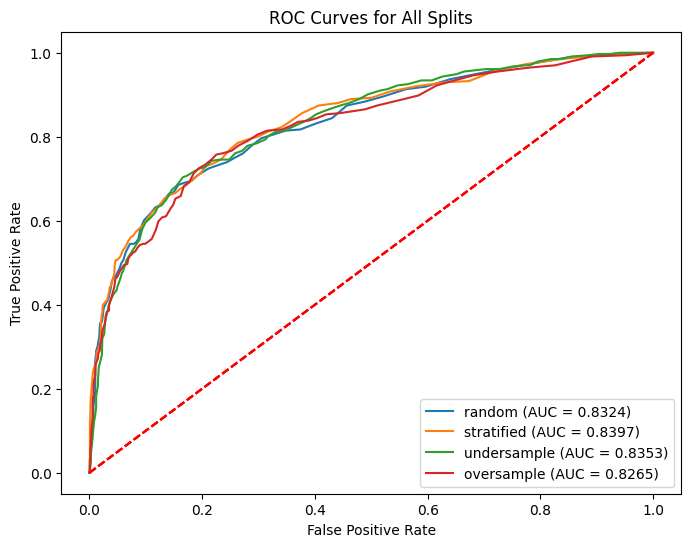

In [66]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, balanced_accuracy_score


#Store our performance results in a dictionary
performance = {}

def evaluating_performance_diff_splits(feature_importances, model=model,split_data=split_data,performance_matrix=performance):

    #Create a 2x2 grid for confusion matrices
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()
    plt.figure(figsize=(8,6))

    #ROC curve figure 
    plt.figure(figsize=(8,6))


    #Train and evaluate the model on each split
    for i, split in enumerate(split_data):
        
        X_train, X_val, y_train, y_val = split_data[split]

        if feature_importances!=[]:
            important_feature_names = [feature[0] for feature in feature_importances[0:9]]
            # Create training and testing sets with only the important features
            X_train = X_train[important_feature_names]
            X_val = X_val[important_feature_names]


        #Train the model
        model.fit(X_train, y_train)

        #Predict on validation set 
        y_val_pred = model.predict(X_val)
       

        #Get predicted probabilities that the validation observations belong to a class    
        y_score = model.predict_proba(X_val)[:, 1]  

        #Plot ROC curve on the same figure for all splits
        fpr, tpr, _ = roc_curve(y_val, y_score)
        roc_auc = auc(fpr,tpr)
        plt.plot(fpr, tpr, label=f'{split} (AUC = {roc_auc:.4f})')


        #Plot the confusion matrix for the validation set 
        conf_matrix = confusion_matrix(y_val, y_val_pred)
        tn, fp, fn, tp = conf_matrix.ravel() #Extracts raw counts from the confusion matrix 
        conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] #Normalize the confusion matrix by the number of true samples per class
        sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2%', cmap='Blues', ax=axes[i], #Plot confusion matrix
                    xticklabels=['Not Exited (0)', 'Exited (1)'],
                    yticklabels=['Not Exited (0)', 'Exited (1)'])
        axes[i].set_title(f'Confusion Matrix - {split} Split')
        axes[i].set_ylabel('Actual')
        axes[i].set_xlabel('Predicted')


        #Generate classification report
        report = classification_report(y_val, y_val_pred,output_dict = True)

        #Calculate balanced accuracy
        balanced_acc = balanced_accuracy_score(y_val, y_val_pred)

        #Define performance metrics
        performance_matrix[split] = {
            'precision': report['1']['precision'],
            'recall': report['1']['recall'],
            'f1-score': report['1']['f1-score'],
            'support': report['1']['support'],
            'roc_auc': roc_auc,
            'balanced_accuracy': balanced_acc
        }


        #Finish off ROC curves
        plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line for random guessing
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curves for All Splits')
        plt.legend(loc='lower right')


    #Show the plots
    plt.show()  
    return performance_matrix


performance = evaluating_performance_diff_splits(feature_importances=[],model=model,split_data=split_data,performance_matrix=performance)
    

- **Random**: The model works well at correctly predicting customers who stay but only accurately identifies 42% of the customers who leave. 
- **Stratified**: We see a slighlty better performance in correctly predicting churn at 48%, but this comes at the cost of accurately identifying the non-churners.
- **Undersample**: The undersample split significantly improves the detection of the churned customers with a TP rate of 73.05%, but it comes at the cost of a worse performance for predicting the non-churners, where only 80.33% are correctly predicted.
- **Oversampled**: The oversampled split results in a similar performance to the stratified split. The balance between the two classes is better than the random split, but still not as strong as the undersampling approach for detecting Exited customers.

The ROC curve presents the trade-off between the True Positive rate and the False Positive rate across different thresholds for predicting the positive class (churn). We see that the model performs reasonably well across all ths splits. Most notabley, the Undersample split has the lowest AUC at 0.8306 even though it correctly predicts the most churned customers. We understand that a higher recall is more important because it is more costly to lose a customer than offer incentives to customers who weren't planning on leaving, hence we seek to minimise false negatives. False negatives is where the model has incorrectly predicted that a customer has not left not exist, when in reality they have. We seek to minimise this since our objective is to gauge a better understanding of the variables that lead to a customer leaving.

In [67]:
performance_df = pd.DataFrame(performance).T

### How well did standard classifier do? 

In [68]:
performance_df

,precision,recall,f1-score,support,roc_auc,balanced_accuracy
random,0.760870,0.419162,0.540541,334.0,0.832439,0.692203
stratified,0.733333,0.472393,0.574627,326.0,0.839679,0.714218
undersample,0.493878,0.724551,0.587379,334.0,0.835271,0.764329
oversample,0.661355,0.497006,0.567521,334.0,0.826450,0.714933


From the performance metrics, we can infer that the stratified split performs best overall. Having a good balance between precision (0.726), recall (0.481), and the highest AUC (0.8438), makes it the most reliable in distinguishing between classes. The undersample split achieves the best recall (0.730) and the highest balanced accuracy (0.766), but at the cost of lower precision (0.494). However, since maximising recall is more critical for correctly predicting the positive class, which is more important for building a generalisable model for the bank, the undersample split might be more suitable. Additionally, having the largest balanced accuracy is influential because it ensures the model performs well on both the majority (not-exited) and minority (exited) classes, which is especially important for our imbalanced dataset, avoiding bias towards the majority class.

## Parameter Tuning 
We perform Random Search Cross Validation for hyperparameter tuning and improve on the current random forest model.

In [69]:
#look at the parameters used by our current forest
print('Parameters currently in use:\n')
model.get_params()

Parameters currently in use:



{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 6,
 'verbose': 0,
 'warm_start': False}

There are quite a lot of parameters so we read the documentation on the random forest in SK-Learn. This tells us that the number of trees in the forest (n_estimators) and the number of features considered at each leaf node (max_features) are the most important things to consider. The most efficient way to determine the best value for these and more is to just try out a wide range of values and see what performs best.
We will try adjust the following parameters:
- n_estimators = number of trees in the foreset
- max_features = max number of features considered for splitting a node
- max_depth = max number of levels in each decision tree
- min_samples_split = min number of data points placed in a node before the node is split
- min_samples_leaf = min number of data points allowed in a leaf node
- bootstrap = method for sampling data points (with or without replacement)

### Hyperparameter grid

In [70]:
# We first need to create a parameter grid

# Number of trees in random forest
n_estimators = [int(x) for x in range(200, 1000, 200)]

# Number of features to consider at every split
max_features = ['log2', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
RS_params = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

RS_params


{'n_estimators': [200, 400, 600, 800],
 'max_features': ['log2', 'sqrt'],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'min_samples_split': [2, 5, 10],
 'min_samples_leaf': [1, 2, 4],
 'bootstrap': [True, False]}

The benefit of random search is that we are not trialing every combination of parameters here, which would be computationally inefficient. Instead, the algorithm selects a combination at random to sample a wide range of values. 

### Random Search Training

We will use the random split since it best represents our original data split into training and unseen data

In [71]:
X_train, X_val, y_train, y_val = split_data['random']

In [72]:

from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import recall_score

#Search across 100 different combinations, and use all available cores
random_search = RandomizedSearchCV(estimator = model, param_distributions = RS_params, n_iter = 100, cv = 5, verbose=0, random_state=6, n_jobs = -1,scoring='recall')

#Fit the random search model
random_search.fit(X_train, y_train)

#Print the best paremters and the best recall score
print("Best parameters found:", random_search.best_params_)
print("Best recall score", random_search.best_score_)



Best parameters found: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 50, 'bootstrap': False}
Best recall score 0.4887822987822988


The best parameters found were: 
- 'n_estimators': 800, so we suggest to test three values: 100 less, the same, and 100 more.
- 'max_features': 'sqrt', we stick to the sqrt method for splitting a node.  
- 'min_samples_split': 10, so we use will try 9, 10 and 11.
- 'min_samples_leaf': 2, so we wil try 1, 2 and 3.
- 'max_depth': 10, let's try 2 above and below this.
- 'bootstrap': True, selected as best sampling technique. 

### Now Grid Search Using the Best Parameters

In [73]:
from sklearn.model_selection import GridSearchCV

#After RandomizedSearchCV, use the best params to create a more focused parameter grid for GridSearchCV
best_params_random = random_search.best_params_

#Define parameter grid for GridSearchCV
GS_params = {
    'n_estimators': [700, 800, 900],  
    'max_features': ['sqrt'], 
    'max_depth': [8, 10, 12],  
    'min_samples_split': [9, 10, 11], 
    'min_samples_leaf': [1, 2, 3], 
    'bootstrap': [True]  
}

# Run GridSearchCV with the refined grid
grid_search = GridSearchCV(estimator=model, param_grid=GS_params, cv=5, verbose=0,  n_jobs=-1,scoring='recall')
grid_search.fit(X_train, y_train)

#Print the best paremters and the best recall score
print("Best parameters found:", grid_search.best_params_)
print("Best recall score", grid_search.best_score_)

Best parameters found: {'bootstrap': True, 'max_depth': 12, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 9, 'n_estimators': 700}
Best recall score 0.4633590733590734


### Evaluate Random Search
To determine if the found parameters does in fact improve model performance, we compare the standard model with the best parameter model.


### Random Search
First we look at if we had just used the parameters from Random Search alone.

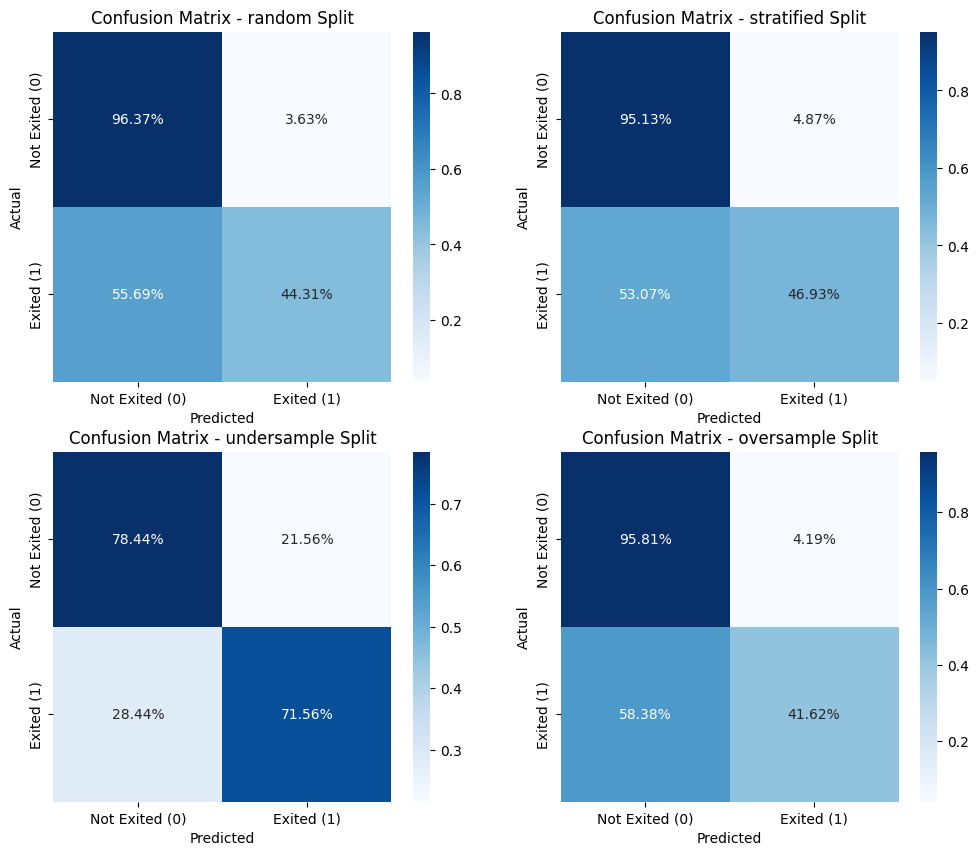

<Figure size 800x600 with 0 Axes>

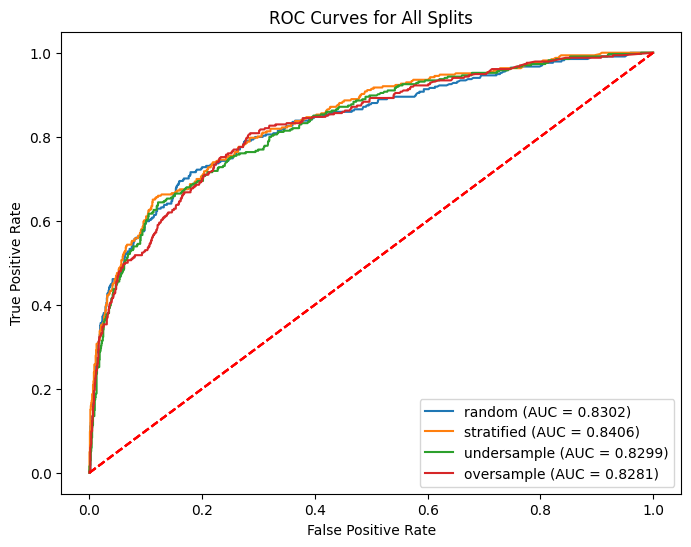

In [74]:
#Create a new model with the identified optimal parameters
RS_parameters = random_search.best_params_

RS_model = RandomForestClassifier(**RS_parameters, random_state = 6)

RS_performance = {}
RS_performance = evaluating_performance_diff_splits(feature_importances=[],model=RS_model,split_data=split_data,performance_matrix=RS_performance)


### Random Search With Grid Search
Now using the knowledge from the random search, we assess if we could use grid search to find better parameters similar to the random search outcome. 

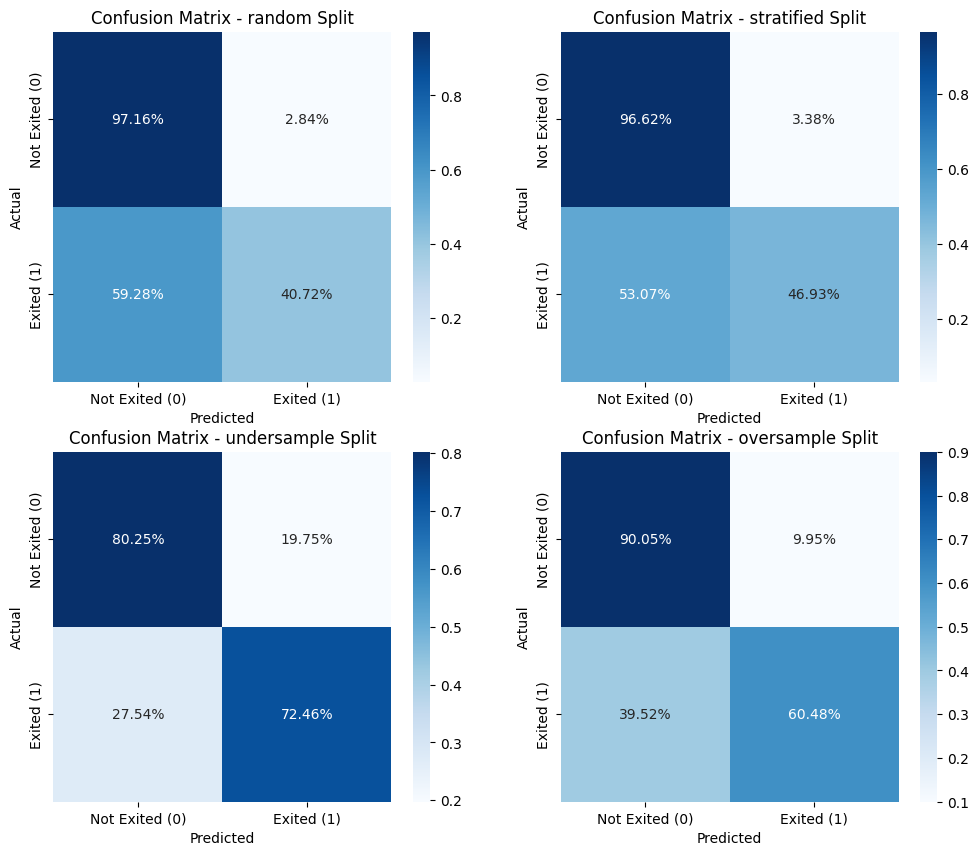

<Figure size 800x600 with 0 Axes>

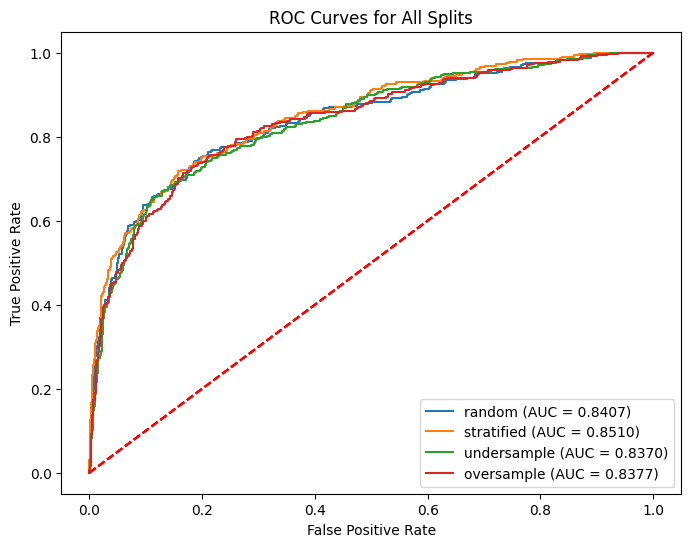

In [75]:

GS_parameters = grid_search.best_params_
GS_model = RandomForestClassifier(**GS_parameters, random_state = 6)
GS_performance = {}
GS_performance = evaluating_performance_diff_splits(feature_importances=[],model=GS_model,split_data=split_data,performance_matrix=GS_performance)


We immediately see an improvement in recall for the oversampled split, but this came at the cost of successfully predicted the retained class, with a decrease in precision.

In [76]:
# Convert to DataFrame and display the results
performance_RS_df = pd.DataFrame(RS_performance).T
# Convert to DataFrame and display the results
performance_GS_df = pd.DataFrame(GS_performance).T


### Which search? 
From the results of the random search and the subsequent grid search, we can see that recall, shows improvement after hyperparameter tuning with grid search. For undersampling, recall improved slightly from 0.716 to 0.725 after grid search. In contrast, oversampling saw a significant improvement in recall from 0.416 to 0.605, although it still didn't outperform undersampling. The recall values for the random and stratified splits remained relatively consistent across both searches, with the stratified split performing slightly better. Since recall is crucial for identifying customers who are likely to churn (where false negatives are particularly costly), the grid search combined with undersampling provided the best result, achieving the highest recall of 0.724551, making it the optimal choice for this task.

### Compare Grid Search the Standard Classifier 
The hyperparameter tuning via grid search has clearly enhanced the performance of the model, particularly in terms of recall and balanced accuracy. For churn prediction, improving recall means more churned customers are correctly identified, which can help businesses create retention schemes. The most notable improvement is seen in the oversampled split, where recall increased from 0.497006 to 0.604790, indicating a more effective detection of churned customers using parameter search. The undersampled split maintained the same high recall of 0.724551, suggesting that undersampling continues to be a reliable method for maximizing recall.

In terms of balanced accuracy, which helps measure performance across both classes (churned and retained customers), the undersampled split remained stable at around 0.764, continuing to balance sensitivity and specificity well. Oversampling saw a significant improvement in balanced accuracy, increasing from 0.714933 to 0.752632, further confirming that grid search improved this method’s ability to identify churn while maintaining overall balance. The stratified and random splits remained relatively stable in both recall and balanced accuracy, with only marginal gains.

All splits demonstrated improvements in AUC, indicating an overall enhancement in the model’s ability to distinguish between retained and churned customers. The stratified split experienced the largest improvement, increasing its AUC from 0.8397 to 0.8510, indicating it has the potential to be the best overall performer. The oversampled split also showed significant improvement, with its AUC rising from 0.8265 to 0.8377, making it a much more competitive technique after parameter tuning. Both the random split and undersampled split saw relatively small AUC increases (from 0.8324 to 0.8407 and from 0.8353 to 0.8370, respectively). These improvements show that fine tuning the model parameters not only enhanced the recall but also led to better overall performance in distinguishing between customers likely to churn and those who will stay, which is critical for targeted customer retention strategies.


### Importance of Parameters


In [77]:
GS_parameters

{'bootstrap': True,
 'max_depth': 12,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 9,
 'n_estimators': 700}

- Bootstrap set to True means that each treee is trained on a slightly different subset of the data which introduces variability because each tree learns from different patterns in the data. This reduces overfitting to the training data and will help the model generalise better to our unseen portion of the data.
- max_depth is arguably set quite high which is likely due to having an imbalanced dataset and the tree needing to perform quite decisions to determine what attributes contribute to predicting the minority churn class.
- max_features means the model will only consider a random subset of sqrt(13) features at each split. This randomness is applied independently at each split in each tree so different trees and different splits will learn from a different subest of features, allowing the model to learn different patterns. 
- min_samples_lead set to 1 means the model grows deep, splitting until each leaf node has only one observation. This will likely cause an issue with generalisability as the model learns fine detail of this particular dataset, thus the model won't perform as well when exposed to new data the bank obtains. 
- Fortunately, min_samples_split balances this slightly by requiring at least 9 observations to make a split. This restricts the growth of the tree, making it less likely to grow deeply. This is beneficial for the ratained class because the model learns generic patterns in the data, allowing it to predict retained customers well in new data. However, this will make it harder for the model to capture specific patterns in the Exited class since it has fewer observations. 
- n_estimators means the model generates 700 individual trees that will be trained and majority vote is performed to make the final predictions. Using this large amount should reduce variance and are less influenced by outliers or specific patterns in the data, allowing for a model that generalises better to new data. 



## Feature Importance
Finally we look at feature importance and see how this affects our model

In [78]:
'''We use the train and test sets from the random split'''
X_train, X_val, y_train, y_val = split_data['random']


In [79]:
feature_list=list(X_train.columns)
# Get numerical feature importances
importances = list(RS_model.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

Variable: Age                  Importance: 0.19
Variable: CreditScoreGivenAge  Importance: 0.16
Variable: NumOfProducts        Importance: 0.12
Variable: CreditScore          Importance: 0.11
Variable: Balance              Importance: 0.11
Variable: TenureByAge          Importance: 0.11
Variable: BalanceSalaryRatio   Importance: 0.09
Variable: IsActiveMember       Importance: 0.04
Variable: Geography_Germany    Importance: 0.03
Variable: Geography_France     Importance: 0.01
Variable: Geography_Spain      Importance: 0.01
Variable: Gender_Female        Importance: 0.01
Variable: Gender_Male          Importance: 0.01


[None, None, None, None, None, None, None, None, None, None, None, None, None]

Some variables have near zero importance so it seems like we should be able to get rid of some of them without impacting performance. First, let’s make a quick graph to represent the relative differences in feature importances. 

[0.11053328661107832, 0.19285866483335876, 0.10688088579823093, 0.12404787651874573, 0.08956234455769574, 0.11066703486605349, 0.1630348094015298, 0.03651613520946495, 0.01105751378567714, 0.025093363544663242, 0.008925779419948536, 0.010474944980111147, 0.010347360473442263]


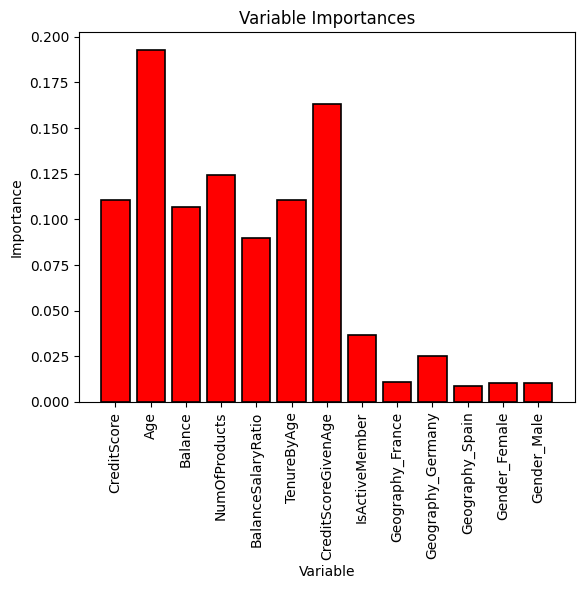

In [80]:
#List of feature locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical', color = 'r', edgecolor = 'k', linewidth = 1.2)
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances')

print(importances)

This depicts the relative differences in the feature importances. 

Text(0.5, 1.0, 'Cumulative Importances')

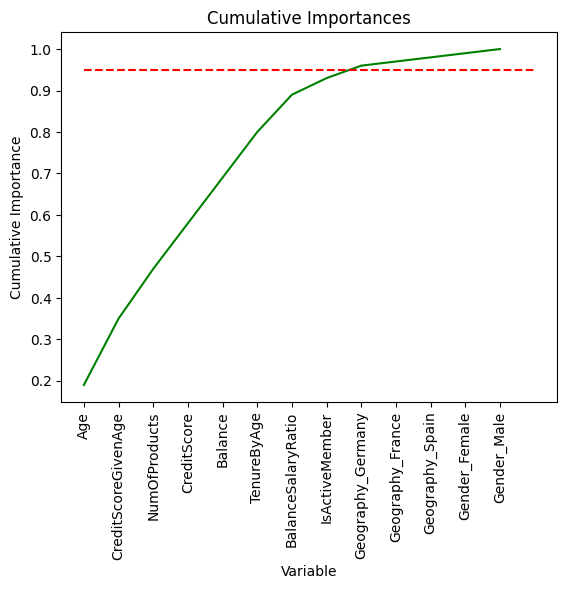

In [81]:
# List of features sorted from most to least important
sorted_importances = [importance[1] for importance in feature_importances]
sorted_features = [importance[0] for importance in feature_importances]
# Cumulative importances
cumulative_importances = np.cumsum(sorted_importances)
# Make a line graph
plt.plot(x_values, cumulative_importances, 'g-')
# Draw line at 95% of importance retained
plt.hlines(y = 0.95, xmin=0, xmax=len(sorted_importances), color = 'r', linestyles = 'dashed')
# Format x ticks and labels
plt.xticks(x_values, sorted_features, rotation = 'vertical')
# Axis labels and title
plt.xlabel('Variable'); plt.ylabel('Cumulative Importance'); plt.title('Cumulative Importances')

This is a gaphh of cumulative importance that shows the contribution to the overall importance of each variable. The dashed line is drawn at 95% of total importance accounted for which means the variables that lie above it can be disregarded and the model should perform at least the same or better. 95% is an arbitrary threshold, but if it leads to noticeably poor performance we can adjust the value. First, we need to find the exact number of features to exceed 95% importance:

In [82]:
# Find number of features for cumulative importance of 95%
# Add 1 because Python is zero-indexed
print('Number of features for 95% importance:', np.where(cumulative_importances > 0.95)[0][0] + 1)

Number of features for 95% importance: 9


We can then create a new training and testing set retaining only the 9 most important features.

In [83]:
# Extract the names of the most important features
important_feature_names = [feature[0] for feature in feature_importances[0:9]]
print(important_feature_names)
# Create training and testing sets with only the important features
important_train_features = X_train[important_feature_names]
important_test_features = X_val[important_feature_names]


# Sanity check on operations
print('Important train features shape:', important_train_features.shape)
print('Important test features shape:', important_test_features.shape)

['Age', 'CreditScoreGivenAge', 'NumOfProducts', 'CreditScore', 'Balance', 'TenureByAge', 'BalanceSalaryRatio', 'IsActiveMember', 'Geography_Germany']
Important train features shape: (6400, 9)
Important test features shape: (1600, 9)


In [84]:
# Train the expanded model on only the important features
RS_model.fit(important_train_features, y_train)
# Make predictions on test data
predictions = RS_model.predict(important_test_features)

report = classification_report(y_val,predictions,output_dict=True)
report['1']


{'precision': 0.7211538461538461,
 'recall': 0.4491017964071856,
 'f1-score': 0.5535055350553506,
 'support': 334.0}

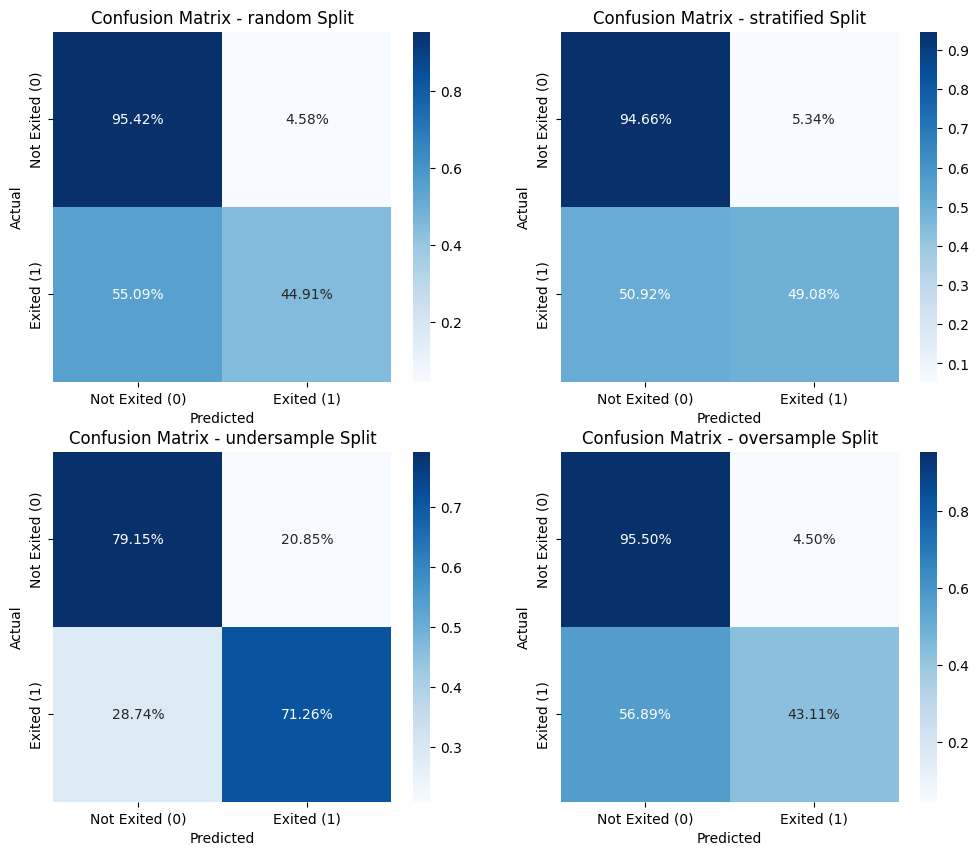

<Figure size 800x600 with 0 Axes>

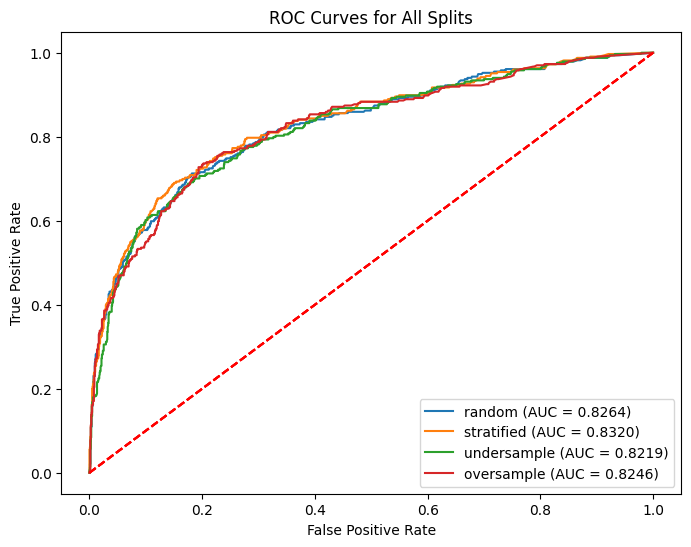

In [85]:
performance_fr = {}
performance_fr = evaluating_performance_diff_splits(feature_importances=feature_importances,model=RS_model,split_data=split_data,performance_matrix=performance_fr)

In [86]:
performance_fr =pd.DataFrame(performance_fr).T
performance_fr

,precision,recall,f1-score,support,roc_auc,balanced_accuracy
random,0.721154,0.449102,0.553506,334.0,0.826449,0.701644
stratified,0.701754,0.490798,0.577617,326.0,0.831999,0.718711
undersample,0.474104,0.712575,0.569378,334.0,0.821852,0.752022
oversample,0.716418,0.431138,0.538318,334.0,0.824634,0.693057


### How Does Feature Reduction Compare with Standard Model?
Random and stratified sampling show significant improvements in recall and overall balanced accurace after feature reduction which helped remove noise/ irrelevant features, which improved the generalisation of the model, correctly predicting more churners. Undersamples split shows a slight reduction in recall and precision, indicating that removing features may have reduced its ability to balance predictions between the classes. Similarly, oversampled split shows a decline in precision but its overall performance remained stable. 

## Final Model
So now we have trained our model we will use it to predict on the unseen test data to see how well our model actually generalises. I will implement both the Grid Search and Feature Importance outcomes to generate one final well-rounded model

In [87]:
print(feature_importances)

[('Age', 0.19), ('CreditScoreGivenAge', 0.16), ('NumOfProducts', 0.12), ('CreditScore', 0.11), ('Balance', 0.11), ('TenureByAge', 0.11), ('BalanceSalaryRatio', 0.09), ('IsActiveMember', 0.04), ('Geography_Germany', 0.03), ('Geography_France', 0.01), ('Geography_Spain', 0.01), ('Gender_Female', 0.01), ('Gender_Male', 0.01)]


In [88]:
GS_model = RandomForestClassifier(**GS_parameters, random_state = 6)


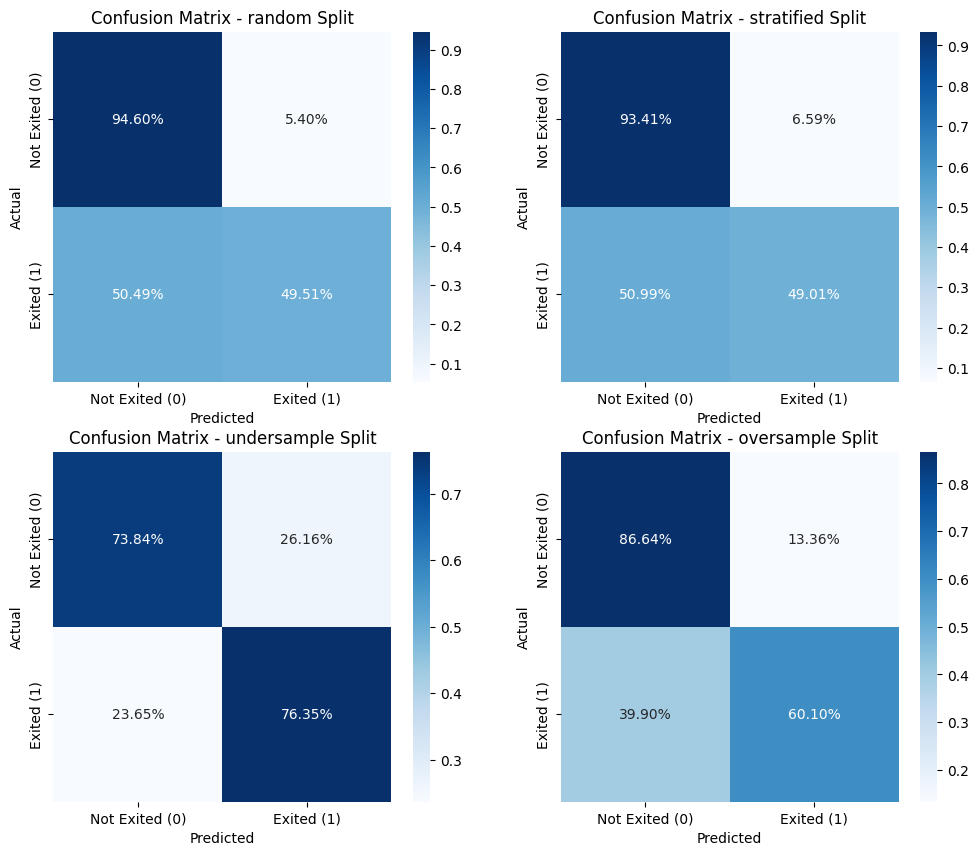

<Figure size 800x600 with 0 Axes>

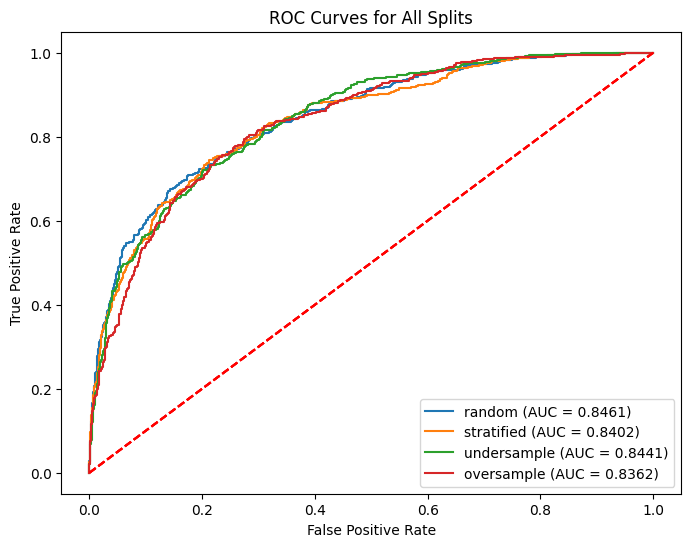

In [89]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, balanced_accuracy_score


final_performance = {}

#Create a 2x2 grid for confusion matrices
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()
plt.figure(figsize=(8,6))

#ROC curve figure 
plt.figure(figsize=(8,6))


#Train and evaluate the model on each split
for i, split in enumerate(split_data):
    
    X_train, X_val, y_train, y_val = split_data[split]


    important_feature_names = [feature[0] for feature in feature_importances[0:9]]

    #Create training and testing sets with only the important features
    X_train = X_train[important_feature_names]
    X_test = X_test_raw[important_feature_names] #reduce features in raw X test set 


    #Train the model
    GS_model.fit(X_train, y_train)

    #Predict on the test set
    y_test_pred = GS_model.predict(X_test)

    #Get predicted probabilities that the test observations belong to a class    
    y_score = GS_model.predict_proba(X_test)[:, 1] 


   

    #Plot ROC curve on the same figure for all splits
    fpr, tpr, _ = roc_curve(y_test_raw, y_score)
    roc_auc = auc(fpr,tpr)
    plt.plot(fpr, tpr, label=f'{split} (AUC = {roc_auc:.4f})')

    #Plot the confusion matrix for the validation set 
    conf_matrix = confusion_matrix(y_test_raw, y_test_pred)
    tn, fp, fn, tp = conf_matrix.ravel() #Extracts raw counts from the confusion matrix 
    conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] #Normalize the confusion matrix by the number of true samples per class
    sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2%', cmap='Blues', ax=axes[i], #Plot confusion matrix
                xticklabels=['Not Exited (0)', 'Exited (1)'],
                yticklabels=['Not Exited (0)', 'Exited (1)'])
    axes[i].set_title(f'Confusion Matrix - {split} Split')
    axes[i].set_ylabel('Actual')
    axes[i].set_xlabel('Predicted')


    #Generate classification report
    report = classification_report(y_test_raw, y_test_pred,output_dict = True)

    #Calculate balanced accuracy
    balanced_acc = balanced_accuracy_score(y_test_raw, y_test_pred)

    #Define performance metrics
    final_performance[split] = {
        'precision': report['1']['precision'],
        'recall': report['1']['recall'],
        'f1-score': report['1']['f1-score'],
        'support': report['1']['support'],
        'roc_auc': roc_auc,
        'balanced_accuracy': balanced_acc
    }


    #Finish off ROC curves
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line for random guessing
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for All Splits')
    plt.legend(loc='lower right')


#Show the plots
plt.show()  


In [90]:
final_performance =pd.DataFrame(performance_fr).T
final_performance

,random,stratified,undersample,oversample
precision,0.721154,0.701754,0.474104,0.716418
recall,0.449102,0.490798,0.712575,0.431138
f1-score,0.553506,0.577617,0.569378,0.538318
support,334.000000,326.000000,334.000000,334.000000
roc_auc,0.826449,0.831999,0.821852,0.824634
balanced_accuracy,0.701644,0.718711,0.752022,0.693057


## Benefits and Drawbacks of the Random Forest

One of the benefits of random forests is their ability to learn non-linear decision boundaries. This ability to capture non-linear relationships is particularly useful here, as the baseline logistic regression model suggested the presence of non-linear relationships among the features. Random forests can capture interactions between features that a simpler linear model might miss, making it a good fit for predicting customer churn, where various demographic, numerical banking information and behavioural featires are involved.

Another important advantage of random forests is feature importance. The random forest function provided insight to the importance of each feature for predicting churn, which was helpful in understanding features that brought potential noise. Interestingly, it only removed four features, all of which were one-hot encoded variables: geography_france, geography_spain, gender_female, and gender_male. Removing these specific features slightly improved the model’s performance, indicating that some of the encoded categories had limited predictive power in distinguishing between churned and retained customers. Our dataset had a lack of features to start with, which has clearly reduced the capability of using random forests feature importance function.  

A further advantage of random forests is parallel processing. Since each tree in the forest is created independently, trees can be generated simultaneously, reducing training time significantly. This was particularly beneficial when we tuned the hyperparameters since the random forest was able to test a large  combinations of parameters to find the optimal set in a relatively short amount of time. In comparison, training the neural network model for the same task took considerably longer, highlighting the efficiency of random forests in handling large parameter spaces and complex datasets.

One drawback is sensitivity to noise. While random forests are generally resistant to overfitting, they can still overfit in cases of noisy data, especially when the data contains irrelevant features or outliers. In this customer churn dataset, noise could appear from factors like inconsistent customer behaviour or the imbalance of customers from each region. This sensitivity to noise means that the model might try to learn extraneous patterns or anomalies, potentially reducing its ability to generalise to new data.

Another limitation is the complexity of parameter tuning. Random forests have a large number of hyperparameters with some causing large computation time or overfitting to noisy data if not taken care of. While parallel processing helped reduce the time needed for tuning, the amount of parameter combinations still made this process computationally demanding.

A final note is that random forests are less interpretable than simpler models like logistic regression or a single decision tree (since the prediction cannot be eplained by only one diagram). While feature importance can provide some insight, it lacks the transparency of other models where relationships between features and the target variable are clearer. For a bank looking to act on customer churn predictions, this interpretability challenge limits the ability to draw direct conclusions. Knowing which features are important is helpful, but understanding precisely how these features influence churn would require more interpretable models or extensive analyses.

### Visualising Random Forest

Since Age was shown to be the most important features, we will analyse how this was used to split a tree

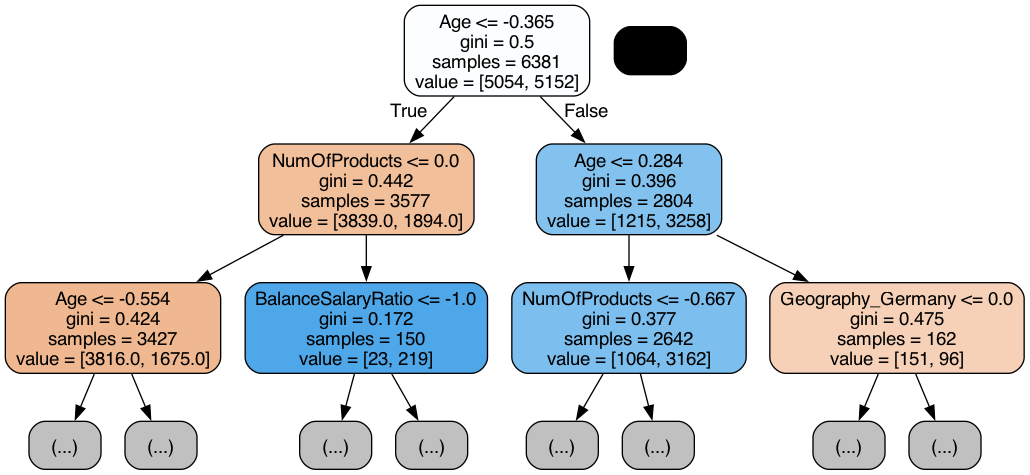

In [91]:
from sklearn.tree import export_graphviz
from io import StringIO
from IPython.display import Image
import pydotplus

estimator5 = GS_model.estimators_[0]
dot_data = StringIO()
export_graphviz(estimator5, out_file=dot_data,max_depth=2,
feature_names=X_train.columns.values,
filled=True, rounded=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

In this decision tree, Age is used repeatedly to split the data and enhance predictive accuracy, emphasising it's feature importance. At the root, the initial split on Age <= -0.365 divides the dataset of 6381 observationd into two groups, followed by further splits by Age within both branches, where it continues to improve class separation and reduce Gini impurity. Splitting on this feature ultimately enhances the model’s ability to generalise, making it a key feature of the models predictive power.

## References

- https://towardsdatascience.com/improving-random-forest-in-python-part-1-893916666cd
- https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
- https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
- https://aiml.com/what-are-the-advantages-and-disadvantages-of-random-forest/